In [14]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(True)

# set device for all tensors
device = 'cpu'

In [1]:
28/0.5

56.0

In [15]:
filepath = '42_dndz_nsamples=24000.h5'
with h5.File(filepath, 'r') as f:
    X = f['hypercube'][:]
    y = f['c_ells'][:]

# Take log of y
y_log = np.log(y)

# Split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, train_size=20000, random_state=seed)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)
y_test = ScalerY.transform(y_test)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)

# Define the model
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function
loss_fn = torch.nn.MSELoss()

force_stop = np.inf

train_losses = []
val_losses = []
converged = False
best_val_loss = np.inf
strike = 0
epoch = 0
start = time()
while not converged:
    epoch_loss = 0
    batch_count = 0
    model.train()
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    # Check for convergence
    epoch += 1
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        val_loss = loss_fn(y_pred, y_test).item()
        val_losses.append(val_loss)

    if best_val_loss - val_loss < 1e-4:
        strike += 1
        if strike > 20 or epoch > force_stop:
            converged = True
            print('Validation loss has not improved for 20 epochs. Converged.')
    else:
        strike = 0
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model.state_dict())

    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch} - avg loss: {avg_epoch_loss} - Strike: {strike}')
    print(time()-start)
    

original_model = deepcopy(model.state_dict())

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

Epoch 1 - avg loss: 0.9065500944852829 - Strike: 0
8.446340560913086


KeyboardInterrupt: 

### Attempt to retrain for new distribution

In [106]:
# Or load a similar task from the training set
# Perform initial training on some other data
n_samples = 1000
# train with latin hypercube samples
# filepath = 'mcmc_dndz_nsamples={}.h5'.format(n_samples)
# with h5.File(filepath, 'r') as f:
#     X_train = f['hypercube'][:]
#     y_train = f['c_ells'][:]

# test with random samples
filepath = 'mcmc_dndz_nsamples=20000.h5'
with h5.File(filepath, 'r') as f:
    X = f['hypercube'][:]
    y = f['c_ells'][:]

# split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_samples, random_state=seed, shuffle=True)

# remove any samples in the training set from the test set
# X_test = np.array([x for x in X_test if x not in X_train])
# y_test = np.array([y for y, x in zip(y_test, X_test) if x not in X_train])

# Take log of y
y_train = np.log(y_train)
y_test = np.log(y_test)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)
    
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=5000, shuffle=False) # train on all samples at once

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

### Fine-tune standard model

Epoch 1/128 avg loss: 0.09565585106611252
Epoch 2/128 avg loss: 0.0815238282084465
Epoch 3/128 avg loss: 0.03735741227865219
Epoch 4/128 avg loss: 0.04995158687233925
Epoch 5/128 avg loss: 0.026760879904031754
Epoch 6/128 avg loss: 0.017641481012105942
Epoch 7/128 avg loss: 0.024768425151705742
Epoch 8/128 avg loss: 0.02279610186815262
Epoch 9/128 avg loss: 0.01755778305232525
Epoch 10/128 avg loss: 0.017294947057962418
Epoch 11/128 avg loss: 0.020120304077863693
Epoch 12/128 avg loss: 0.017494961619377136
Epoch 13/128 avg loss: 0.013292789459228516
Epoch 14/128 avg loss: 0.012098339386284351
Epoch 15/128 avg loss: 0.013729787431657314
Epoch 16/128 avg loss: 0.013659498654305935
Epoch 17/128 avg loss: 0.0122537761926651
Epoch 18/128 avg loss: 0.01067295577377081
Epoch 19/128 avg loss: 0.010052924044430256
Epoch 20/128 avg loss: 0.009543044492602348
Epoch 21/128 avg loss: 0.008197834715247154
Epoch 22/128 avg loss: 0.007650443818420172
Epoch 23/128 avg loss: 0.00773030798882246
Epoch 24

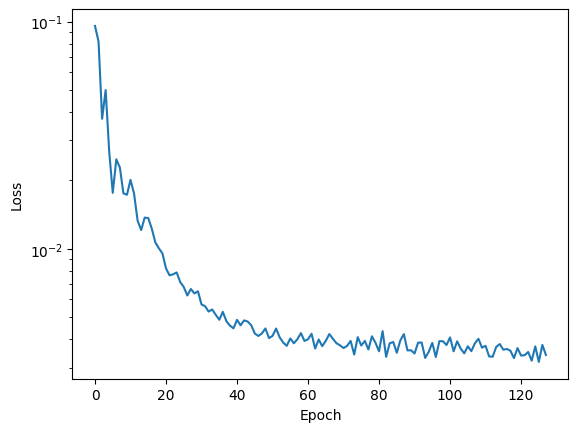

In [107]:
n_epochs = 128

model.load_state_dict(original_model)
# OR retrain the model from scratch ###
# model = models.FastWeightCNN(
#     input_size=10,
#     latent_dim=(16,16),
#     output_size=750,
#     dropout_rate=0.2
# )
# Define new optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)
model.train()
train_losses = []
for epoch in range(n_epochs):
    epoch_loss = 0
    batch_count = 0
    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{n_epochs} avg loss: {avg_epoch_loss}')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

### Load and finetune MAML model on the MCMC data

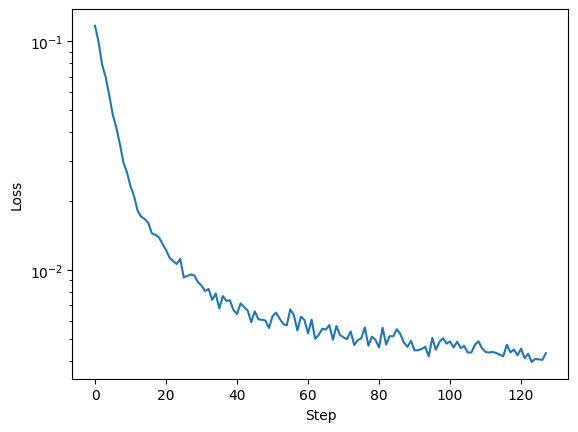

In [108]:
maml_model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Create a new MetaLearner instance
metalearner = training.MetaLearner(
    model=maml_model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device=device
)

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(5, 1000, 20)
    )
)

# Perform finetuning
task_weights, losses = metalearner.finetune(X_train, y_train, adapt_steps=n_epochs, use_new_adam=True)

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

### Compare models

Total predictions: torch.Size([19000, 750])
Total predictions: torch.Size([19000, 750])
MAML MAPE: 2.2583144
Standard MAPE: 2.5587559
MAML XAPE: 55.28634
Standard XAPE: 39.95345
MAML Failure Rate: 0.05221052631578947
Standard Failure Rate: 0.050473684210526316


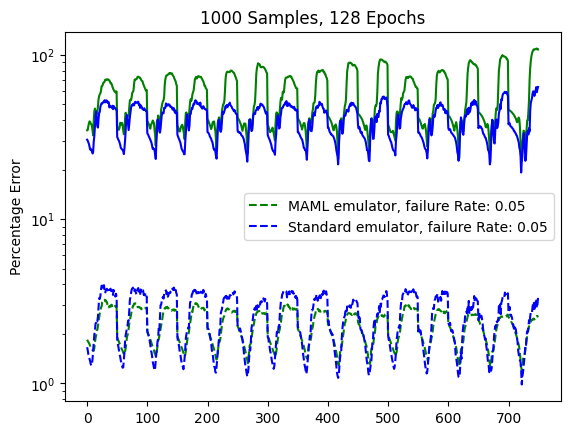

In [109]:
############# MAML TRAINING #############
# Construct empty tensor to store 
metalearner.model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    model.eval()
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=task_weights)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
maml_mape = np.mean(apes, axis=0)
maml_xape = np.max(apes, axis=0)
maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)
plt.plot(maml_mape, c='g', ls='--', label='MAML emulator, failure Rate: {:.2f}'.format(maml_frate))
plt.plot(maml_xape, c='g', ls='-')
plt.yscale('log')

############# STANDARD TRAINING #############
# Construct empty tensor to store predictions
model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = model(X_batch)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
standard_mape = np.mean(apes, axis=0)
standard_xape = np.max(apes, axis=0)
standard_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)
plt.plot(standard_mape, c='b', ls='--', label='Standard emulator, failure Rate: {:.2f}'.format(standard_frate))
plt.plot(standard_xape, c='b', ls='-')
plt.ylabel('Percentage Error')
plt.legend()
plt.title(f'{n_samples} Samples, {n_epochs} Epochs')

print('MAML MAPE:', np.mean(maml_mape))
print('Standard MAPE:', np.mean(standard_mape))

print('MAML XAPE:', np.mean(maml_xape))
print('Standard XAPE:', np.mean(standard_xape))

print('MAML Failure Rate:', maml_frate)
print('Standard Failure Rate:', standard_frate)

750
Tracer combs: [('src0', 'src0'), ('src1', 'src0'), ('src1', 'src1'), ('src2', 'src0'), ('src2', 'src1'), ('src2', 'src2'), ('src3', 'src0'), ('src3', 'src1'), ('src3', 'src2'), ('src3', 'src3'), ('src4', 'src0'), ('src4', 'src1'), ('src4', 'src2'), ('src4', 'src3'), ('src4', 'src4')]


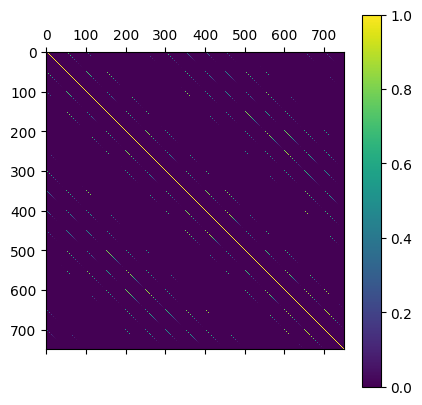

In [76]:
# Load in fiducial data
S = sacc.Sacc.load_fits('mcmc/sacc_fiducial_data.fits')
print(S.mean.size)

# Define tracer combs
tracer_combs = S.get_tracer_combinations()
print('Tracer combs:', tracer_combs)

# Extract C_ell and covariance blocks
c_ells = []
for comb in tracer_combs:
    ell, cell = S.get_ell_cl(
        data_type='cl_ee',
        tracer1=comb[0],
        tracer2=comb[1],
        return_cov=False
    )
    c_ells.append(cell)

# get covariance matrix
cov_full = S.covariance.covmat

# compute correlation matrix
corr = cov_full / np.sqrt(np.outer(np.diag(cov_full), np.diag(cov_full)))
plt.matshow(corr, cmap='viridis')
plt.colorbar()

In [25]:
# Define the likelihood function to use emulator with batching
def log_likelihood(theta_batch, data, inv_cov):
    # Assume theta_batch has shape (n_walkers, n_params)
    
    # Set to eval mode
    model.eval()
    
    # Send inputs to PyTorch tensor and apply scaling
    theta_tensor = torch.tensor(theta_batch, dtype=torch.float32).to(device)
    theta_tensor = ScalerX.transform(theta_tensor)
    
    # Compute the model vector in a batch
    with torch.no_grad():
        model_vectors = model(theta_tensor)  # Shape: (n_walkers, output_dim)
        model_vectors = torch.exp(ScalerY.inverse_transform(model_vectors))  # Inverse transform
    
    # Transfer results to CPU and convert to numpy
    model_vectors = model_vectors.cpu().detach().numpy()
    
    # Compute the log likelihood for each walker
    diffs = data - model_vectors  # Shape: (n_walkers, output_dim)
    log_likes = -0.5 * np.einsum("ij,ij->i", diffs, np.dot(inv_cov, diffs.T).T)
    
    return log_likes  # Return a vector of log-likelihoods

def log_prior(theta, priors):
    # Vectorized check of priors
    in_bounds = np.array([all(prior[0] < t < prior[1] for prior, t in zip(priors, theta_row)) for theta_row in theta])
    return np.where(in_bounds, 0.0, -np.inf)

def log_probability(theta_batch, priors, data, inv_cov):
    lp = log_prior(theta_batch, priors)
    # Only proceed with log-likelihood computation for valid prior cases
    mask = np.isfinite(lp)
    ll = np.full_like(lp, -np.inf)  # Initialize ll with -inf
    ll[mask] = log_likelihood(theta_batch[mask], data, inv_cov)  # Compute only for valid priors
    
    return lp + ll  # Returns an array of log-probabilities

In [26]:
# test the likelihood function
theta = [0.27, 0.045, 0.67, 0.83, 0.96]

n_bins = len(S.tracers)
print('Number of bins:', n_bins)

# Comment out if not using shifts
for i in range(n_bins):
    theta.append(0.0)

inv_cov = np.linalg.inv(cov_full)
data_vector = np.concatenate(c_ells)
print('Data vector shape:', data_vector.shape)

# Initialize the walkers
nwalkers = 128
ndim = len(theta)

# Define the priors
priors = [
    (0.1, 0.9), # Omega_c
    (0.01, 0.1), # Omega_b
    (0.5, 0.9), # h
    (0.7, 1.0), # sigma8
    (0.8, 1.1) # n_s
]

# Comment out if not using shifts
delta_z = 0.002 # LSST Y1 mean uncertainty
for i in range(n_bins):
    priors.append((-delta_z, delta_z)) # Shifts for each redshift bin

# Define the initial positions
pos = [
    theta[0] + 1e-2 * np.random.randn(nwalkers), # Omega_c
    theta[1] + 1e-3 * np.random.randn(nwalkers), # Omega_b
    theta[2] + 1e-2 * np.random.randn(nwalkers), # h
    theta[3] + 1e-2 * np.random.randn(nwalkers), # sigma8
    theta[4] + 1e-2 * np.random.randn(nwalkers), # n_s
]

# Comment out if not using shifts
for i in range(n_bins):
    pos += (theta[5+i] + 1e-4 * np.random.randn(nwalkers),)
pos = np.array(pos).T

Number of bins: 5
Data vector shape: (750,)


In [27]:
mcmc_dir = 'mcmc'

#Check for existing backend file
clobber=True
backend_file = os.path.join(mcmc_dir, '{}walkers_chain_outputs_emulator.h5'.format(nwalkers))
if os.path.exists(backend_file) and clobber:
    print("Clobbering existing backend file")
    os.remove(backend_file)

if os.path.exists(backend_file):
    backend = emcee.backends.HDFBackend(backend_file)
    if backend.iteration > 0: # If the file is empty, start from scratch
        pos = None # backend will resume from previous position by default
        print("Resuming from existing backend file at iteration {}".format(backend.iteration))
    else:
        backend.reset(nwalkers, ndim) # Reset the backend
        print("Existing backend file found but is empty. Starting from scratch")
else:
    backend = emcee.backends.HDFBackend(backend_file)
    backend.reset(nwalkers, ndim) # Reset the backend
    print("No existing backend file found. Starting from scratch")

converged = False # Convergence flag
chain_len = 1000
max_iter = 50000

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_probability,
    args=(priors, data_vector, inv_cov),
    vectorize=True,
    backend=backend
)

while not converged:
    # Sample 
    start = time()
    sampler.run_mcmc(pos, chain_len, progress=True)
    end = time()

    # Check convergence
    try:
        tau = sampler.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < sampler.iteration)
        print("Current iteration: {}".format(sampler.iteration))
        print("Rounded autocorrelation times: {}".format((tau * 50).astype(int)))
    except emcee.autocorr.AutocorrError:
        print("Autocorrelation time could not be estimated. Continuing...")

    if sampler.iteration >= max_iter:
        print("Maximum number of iterations reached without convergence. Exiting...")
        break

print("Sampling completed in {} iterations".format(sampler.iteration))

Clobbering existing backend file
No existing backend file found. Starting from scratch


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


Current iteration: 1000
Rounded autocorrelation times: [4359 4409 4435 4541 4371 4731 4228 4376 4486 4375]


100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


Current iteration: 2000
Rounded autocorrelation times: [8321 8529 8674 7761 8081 7366 7832 7518 8099 8206]


100%|██████████| 1000/1000 [02:30<00:00,  6.64it/s]


Current iteration: 3000
Rounded autocorrelation times: [10456 10395 10906 10113 10766  9155  9286  9125  9923 10097]


100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]


Current iteration: 4000
Rounded autocorrelation times: [11748 11560 12133 11187 12164 10897 10462 11034 11125 10855]


100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


Current iteration: 5000
Rounded autocorrelation times: [12288 12547 12887 11711 12972 12333 11707 12453 12164 11350]


100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s]


Current iteration: 6000
Rounded autocorrelation times: [13284 13453 13807 12351 13634 13535 11961 13337 13137 12988]


100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


Current iteration: 7000
Rounded autocorrelation times: [15007 14946 15244 12739 14460 14649 12434 13807 13355 13277]


100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


Current iteration: 8000
Rounded autocorrelation times: [14959 15349 15715 12977 14905 15377 13162 14074 13712 13909]


100%|██████████| 1000/1000 [02:50<00:00,  5.88it/s]


Current iteration: 9000
Rounded autocorrelation times: [15812 15841 16337 13213 15346 15564 14128 14003 14177 14058]


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


Current iteration: 10000
Rounded autocorrelation times: [16106 16359 17021 13433 16087 15810 14888 14171 14885 14588]


100%|██████████| 1000/1000 [02:47<00:00,  5.95it/s]


Current iteration: 11000
Rounded autocorrelation times: [16308 16426 17301 13491 16509 16370 14927 14380 14999 14969]


100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


Current iteration: 12000
Rounded autocorrelation times: [16879 16824 17638 13817 16684 16632 15418 14198 14978 15373]


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


Current iteration: 13000
Rounded autocorrelation times: [17243 17014 17951 13872 16950 16948 15544 14521 15216 15403]


100%|██████████| 1000/1000 [02:52<00:00,  5.78it/s]


Current iteration: 14000
Rounded autocorrelation times: [17283 17251 17994 13874 17033 17053 15537 14780 15430 15562]


100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


Current iteration: 15000
Rounded autocorrelation times: [17659 17908 18699 13955 17582 17097 15788 15142 15736 15852]


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Current iteration: 16000
Rounded autocorrelation times: [18028 18578 19193 14314 17943 17162 15990 15487 16108 16331]


100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


Current iteration: 17000
Rounded autocorrelation times: [18251 18888 19724 14449 18397 17079 16393 16106 16781 16326]


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


Current iteration: 18000
Rounded autocorrelation times: [18778 19369 20196 14889 18855 17492 16696 16432 16953 16435]


100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


Current iteration: 19000
Rounded autocorrelation times: [18867 19408 20551 14928 19368 17851 16834 16459 16939 16464]


100%|██████████| 1000/1000 [02:49<00:00,  5.91it/s]


Current iteration: 20000
Rounded autocorrelation times: [19186 19817 20945 14885 19789 18291 17021 16571 17185 16661]


100%|██████████| 1000/1000 [02:40<00:00,  6.21it/s]


Current iteration: 21000
Rounded autocorrelation times: [19660 20069 21368 15038 20206 18385 17010 16505 17373 16718]


100%|██████████| 1000/1000 [02:46<00:00,  6.02it/s]


Current iteration: 22000
Rounded autocorrelation times: [19467 20101 21306 15120 20281 18486 17279 16424 17324 16937]
Sampling completed in 22000 iterations


## MAML Finetuning and MCMC

In [28]:
# Define the likelihood function to use emulator with batching
def log_likelihood(theta_batch, data, inv_cov):
    # Assume theta_batch has shape (n_walkers, n_params)
    
    # Set to train mode
    metalearner.model.eval()
    
    # Send inputs to PyTorch tensor and apply scaling
    theta_tensor = torch.tensor(theta_batch, dtype=torch.float32).to(device)
    theta_tensor = ScalerX.transform(theta_tensor)
    
    # Compute the model vector in a batch
    with torch.no_grad():
        model_vectors = metalearner.model(theta_tensor, params=task_weights)  # Shape: (n_walkers, output_dim)
        model_vectors = torch.exp(ScalerY.inverse_transform(model_vectors))  # Inverse transform
        model_vectors = model_vectors.cpu().detach().numpy()
        
    # Compute the log likelihood for each walker
    diffs = data - model_vectors  # Shape: (n_walkers, output_dim)
    log_likes = -0.5 * np.einsum("ij,ij->i", diffs, np.dot(inv_cov, diffs.T).T)
    
    return log_likes  # Return a vector of log-likelihoods

def log_prior(theta, priors):
    # Vectorized check of priors
    in_bounds = np.array([all(prior[0] < t < prior[1] for prior, t in zip(priors, theta_row)) for theta_row in theta])
    return np.where(in_bounds, 0.0, -np.inf)

def log_probability(theta_batch, priors, data, inv_cov):
    lp = log_prior(theta_batch, priors)
    # Only proceed with log-likelihood computation for valid prior cases
    mask = np.isfinite(lp)
    ll = np.full_like(lp, -np.inf)  # Initialize ll with -inf
    ll[mask] = log_likelihood(theta_batch[mask], data, inv_cov)  # Compute only for valid priors
    
    return lp + ll  # Returns an array of log-probabilities

In [29]:
# test the likelihood function
theta = [0.27, 0.045, 0.67, 0.83, 0.96]

n_bins = len(S.tracers)
print('Number of bins:', n_bins)

# Comment out if not using shifts
for i in range(n_bins):
    theta.append(0.0)

inv_cov = np.linalg.inv(cov_full)
data_vector = np.concatenate(c_ells)
print('Data vector shape:', data_vector.shape)

# Initialize the walkers
nwalkers = 128
ndim = len(theta)

# Define the priors
priors = [
    (0.1, 0.9), # Omega_c
    (0.01, 0.1), # Omega_b
    (0.5, 0.9), # h
    (0.7, 1.0), # sigma8
    (0.8, 1.1) # n_s
]

# Comment out if not using shifts
delta_z = 0.002 # LSST Y1 mean uncertainty
for i in range(n_bins):
    priors.append((-delta_z, delta_z)) # Shifts for each redshift bin

# Define the initial positions
pos = [
    theta[0] + 1e-2 * np.random.randn(nwalkers), # Omega_c
    theta[1] + 1e-3 * np.random.randn(nwalkers), # Omega_b
    theta[2] + 1e-2 * np.random.randn(nwalkers), # h
    theta[3] + 1e-2 * np.random.randn(nwalkers), # sigma8
    theta[4] + 1e-2 * np.random.randn(nwalkers), # n_s
]

# Comment out if not using shifts
for i in range(n_bins):
    pos += (theta[5+i] + 1e-4 * np.random.randn(nwalkers),)
pos = np.array(pos).T

Number of bins: 5
Data vector shape: (750,)


In [30]:
mcmc_dir = 'mcmc'

#Check for existing backend file
clobber=True
backend_file = os.path.join(mcmc_dir, '{}walkers_chain_outputs_MAML.h5'.format(nwalkers))
if os.path.exists(backend_file) and clobber:
    print("Clobbering existing backend file")
    os.remove(backend_file)

if os.path.exists(backend_file):
    backend = emcee.backends.HDFBackend(backend_file)
    if backend.iteration > 0: # If the file is empty, start from scratch
        pos = None # backend will resume from previous position by default
        print("Resuming from existing backend file at iteration {}".format(backend.iteration))
    else:
        backend.reset(nwalkers, ndim) # Reset the backend
        print("Existing backend file found but is empty. Starting from scratch")
else:
    backend = emcee.backends.HDFBackend(backend_file)
    backend.reset(nwalkers, ndim) # Reset the backend
    print("No existing backend file found. Starting from scratch")

converged = False # Convergence flag
chain_len = 1000
max_iter = 50000

# Set up the sampler
maml_sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_probability,
    args=(priors, data_vector, inv_cov),
    vectorize=True,
    backend=backend
)

while not converged:
    # Sample 
    start = time()
    maml_sampler.run_mcmc(pos, chain_len, progress=True)
    end = time()

    # Check convergence
    try:
        tau = maml_sampler.get_autocorr_time(tol=0)
        converged = np.all(tau * 50 < maml_sampler.iteration)
        print("Current iteration: {}".format(maml_sampler.iteration))
        print("Rounded autocorrelation times: {}".format((tau * 50).astype(int)))
    except emcee.autocorr.AutocorrError:
        print("Autocorrelation time could not be estimated. Continuing...")

    if maml_sampler.iteration >= max_iter:
        print("Maximum number of iterations reached without convergence. Exiting...")
        break

print("Sampling completed in {} iterations".format(maml_sampler.iteration))

Clobbering existing backend file
No existing backend file found. Starting from scratch


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


Current iteration: 1000
Rounded autocorrelation times: [4442 4579 4476 4470 4590 4440 4380 4211 4457 4378]


 90%|████████▉ | 897/1000 [02:32<00:17,  5.87it/s]


KeyboardInterrupt: 

In [31]:
# load in the data
numerical_reader = emcee.backends.HDFBackend('mcmc/76walkers_chain_outputs.h5', read_only=True)
emulator_reader = emcee.backends.HDFBackend('mcmc/128walkers_chain_outputs_emulator.h5', read_only=True)
maml_reader = emcee.backends.HDFBackend('mcmc/128walkers_chain_outputs_MAML.h5', read_only=True)

In [32]:
print(emulator_reader.get_autocorr_time())
print(np.mean(sampler.acceptance_fraction))
print('-----------------------------')
print(maml_reader.get_autocorr_time())
print(np.mean(maml_sampler.acceptance_fraction))

[389.35731016 402.02302288 426.13810747 302.40961047 405.63411067
 369.73411094 345.58152303 328.48002747 346.48924    338.75543357]
0.22434410511363634
-----------------------------


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 38;
tau: [170.35031636 167.19598703 166.79025545 158.18144504 156.24426478
 140.3590912  142.32418345 150.24859019 156.21203991 157.07620044]

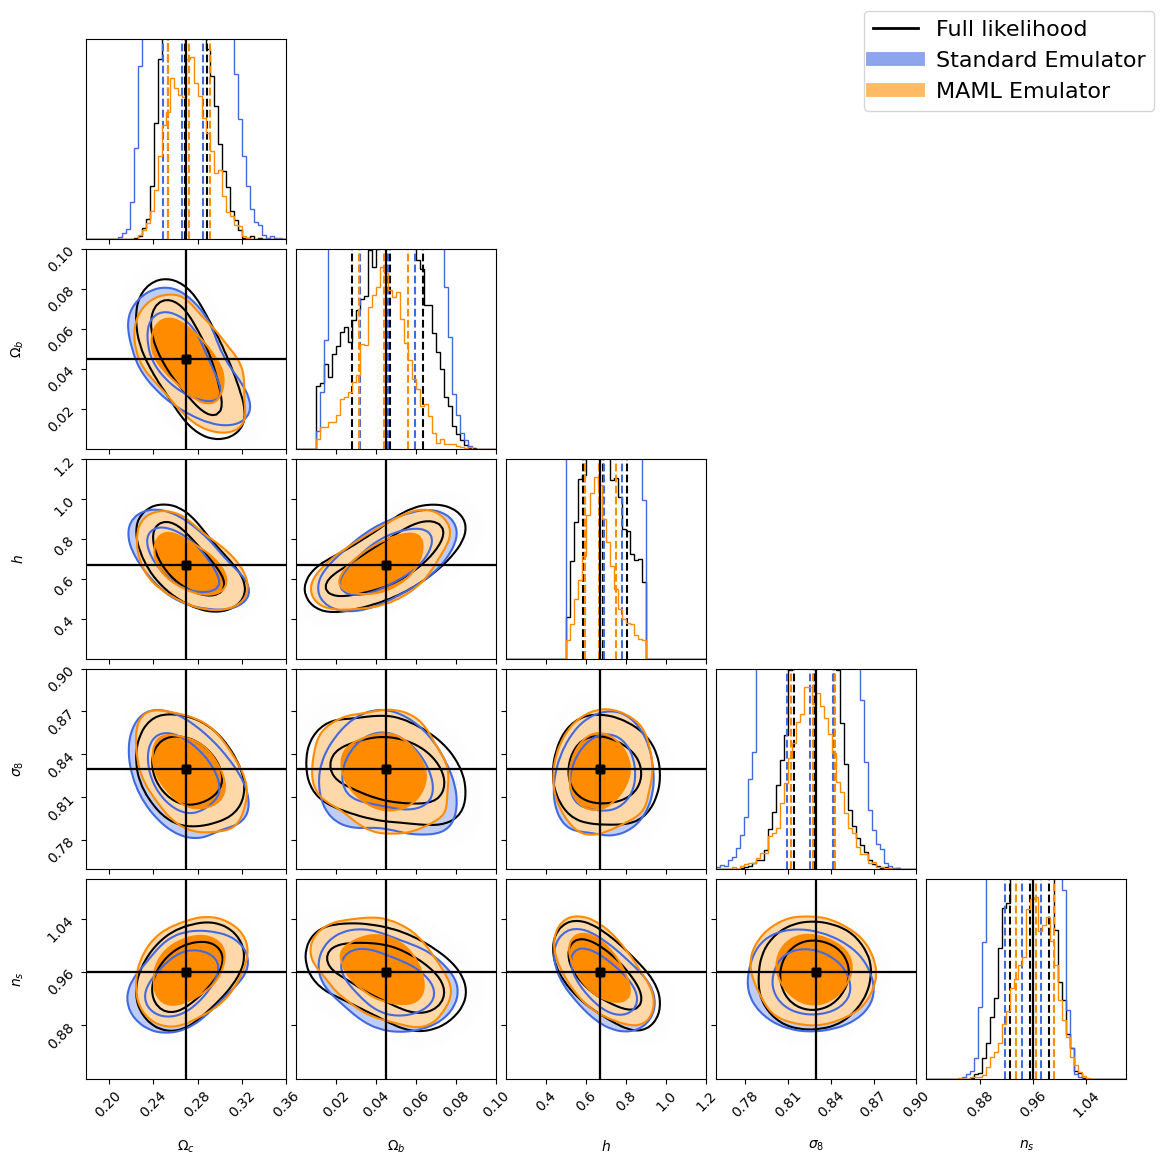

In [ ]:
numerical_samples = numerical_reader.get_chain(discard=1000, thin=150, flat=True)[:,:5]
emulator_samples = emulator_reader.get_chain(discard=200, thin=50, flat=True)[:,:5]
maml_samples = maml_reader.get_chain(discard=200, thin=50, flat=True)[:,:5]

labels = [r"$\Omega_c$", r"$\Omega_b$", r"$h$", r"$\sigma_8$", r"$n_s$", r"$\delta^z_1$", r"$\delta^z_2$", ]
# Plot the corner plot
fig = corner.corner(
    numerical_samples, 
    labels=labels[:5], 
    truths=[0.27, 0.045, 0.67, 0.83, 0.96],
    quantiles=[0.16, 0.5, 0.84],
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color='k',
    truth_color='k',
    smooth=3.0,
    bins=50,
    range=[(0.18, 0.36), (0.0, 0.1), (0.2, 1.2), (0.76, 0.9), (0.8, 1.1)],
)

# Add emulator samples
corner.corner(
    emulator_samples, 
    labels=labels[:5], 
    truths=[0.27, 0.045, 0.67, 0.83, 0.96],
    quantiles=[0.16, 0.5, 0.84],
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=True,
    plot_density=True,
    color='royalblue',
    truth_color='k',
    smooth=3.0,
    bins=50,
    range=[(0.18, 0.36), (0.0, 0.1), (0.2, 1.2), (0.76, 0.9), (0.8, 1.1)],
    fig=fig
)

# Add MAML samples
corner.corner(
    maml_samples, 
    labels=labels[:5], 
    truths=[0.27, 0.045, 0.67, 0.83, 0.96],
    quantiles=[0.16, 0.5, 0.84],
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=True,
    plot_density=True,
    color='darkorange',
    truth_color='k',
    smooth=3.0,
    bins=50,
    range=[(0.18, 0.36), (0.0, 0.1), (0.2, 1.2), (0.76, 0.9), (0.8, 1.1)],
    fig=fig
)

handles = [
    plt.Line2D([0], [0], color='k', lw=2, alpha=1, label='Full likelihood'),
    plt.Line2D([0], [0], color='royalblue', lw=10, alpha=0.6, label='Standard Emulator'),
    plt.Line2D([0], [0], color='darkorange', lw=10, alpha=0.6, label='MAML Emulator')
]

fig.legend(handles=handles, loc='upper right', fontsize=16)
plt.savefig('mcmc/mcmc_compare.png', dpi=300)